# Libraries and dataset import

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# custom matplotlib parameters for vizualizations
plt.rcParams['figure.figsize'] = (14,4)
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['figure.frameon'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams["font.family"] = "monospace"

# color palette
colors = ["#bfd3e6", "#9b5b4f", "#4e4151", "#dbba78", "#bb9c55", "#909195","#dc1e1e","#a02933","#716807","#717cb4"]

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import optuna

In [11]:
# import dataset
house = pd.read_csv('./data/train.csv')
house_test = pd.read_csv('./data/test.csv')

house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [12]:
house.describe().T.style.bar(subset=['mean'],color=colors[5]).background_gradient(subset=['std', '50%', 'max'])

,count,mean,std,min,25%,50%,75%,max
Id,1460.000000,730.500000,421.610009,1.000000,365.750000,730.500000,1095.250000,1460.000000
MSSubClass,1460.000000,56.897260,42.300571,20.000000,20.000000,50.000000,70.000000,190.000000
LotFrontage,1201.000000,70.049958,24.284752,21.000000,59.000000,69.000000,80.000000,313.000000
LotArea,1460.000000,10516.828082,9981.264932,1300.000000,7553.500000,9478.500000,11601.500000,215245.000000
OverallQual,1460.000000,6.099315,1.382997,1.000000,5.000000,6.000000,7.000000,10.000000
OverallCond,1460.000000,5.575342,1.112799,1.000000,5.000000,5.000000,6.000000,9.000000
YearBuilt,1460.000000,1971.267808,30.202904,1872.000000,1954.000000,1973.000000,2000.000000,2010.000000
YearRemodAdd,1460.000000,1984.865753,20.645407,1950.000000,1967.000000,1994.000000,2004.000000,2010.000000
MasVnrArea,1452.000000,103.685262,181.066207,0.000000,0.000000,0.000000,166.000000,1600.000000
BsmtFinSF1,1460.000000,443.639726,456.098091,0.000000,0.000000,383.500000,712.250000,5644.000000


# EDA

## Checking target variable (SalePrice) for its distribution

Text(0.5, 1.0, 'Sales')

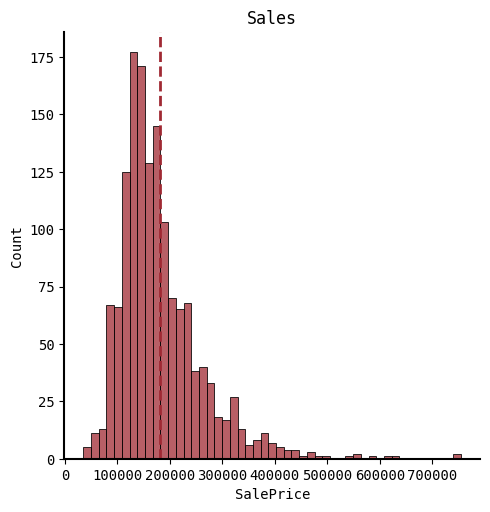

In [13]:
sns.displot(house['SalePrice'], color=colors[7])
plt.axvline(x=house['SalePrice'].mean(), color=colors[7], linestyle='--', linewidth=2)
plt.title('Sales')

## Dealing with missing values

Text(0.5, 1.0, 'Missing Data')

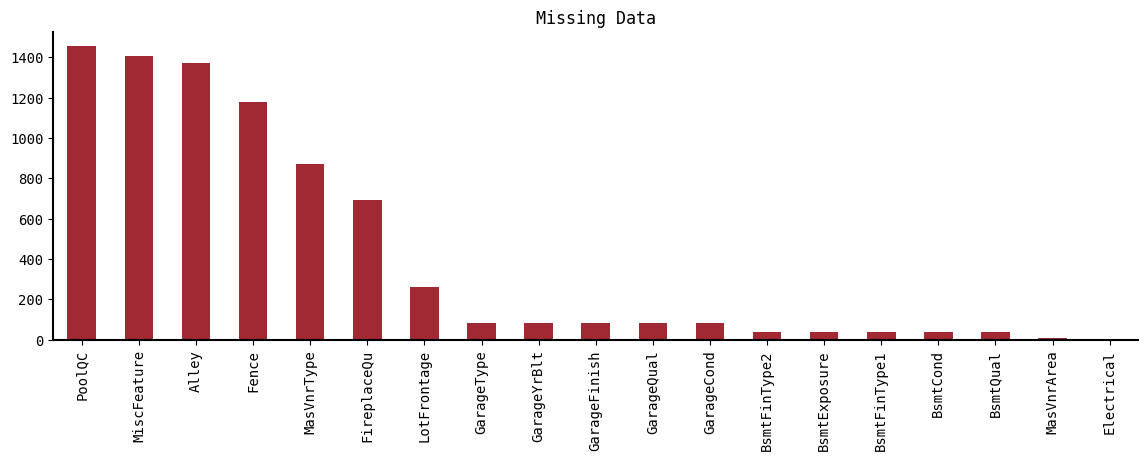

In [14]:
missing = house.isnull().sum()
missing = missing[missing > 0]
missing = missing.sort_values(ascending = False)
missing.plot.bar(color=colors[7])
plt.title('Missing Data')

- Some data has more than 50% or more missing data. So that data is not usable and will be dropped.

## Data preprocessing

In [15]:
y = house['SalePrice']
house = house.drop(['Id', 'Alley', 'PoolQC', 'Fence', 'MiscFeature', 'SalePrice'], axis=1)
house_test = house_test.drop(['Id', 'Alley', 'PoolQC', 'Fence', 'MiscFeature'], axis=1)

In [16]:
house.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,61,0,0,0,0,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,42,0,0,0,0,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,35,272,0,0,0,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,84,0,0,0,0,0,12,2008,WD,Normal


In [17]:
num_cols = [col for col in house.columns if house[col].dtype in ['float64', 'int64']]
cat_cols = [col for col in house.columns if house[col].dtype not in ['float64', 'int64']]

In [18]:
house[num_cols] = SimpleImputer().fit_transform(house[num_cols])
house_test[num_cols] = SimpleImputer().fit_transform(house_test[num_cols])

house[num_cols] = MinMaxScaler().fit_transform(house[num_cols])
house_test[num_cols] = MinMaxScaler().fit_transform(house_test[num_cols])

In [19]:
display(house[num_cols])

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0.235294,0.150685,0.033420,0.666667,0.500,0.949275,0.883333,0.122500,0.125089,0.000000,...,0.386460,0.000000,0.111517,0.000000,0.0,0.0,0.0,0.00000,0.090909,0.50
1,0.000000,0.202055,0.038795,0.555556,0.875,0.753623,0.433333,0.000000,0.173281,0.000000,...,0.324401,0.347725,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.363636,0.25
2,0.235294,0.160959,0.046507,0.666667,0.500,0.934783,0.866667,0.101250,0.086109,0.000000,...,0.428773,0.000000,0.076782,0.000000,0.0,0.0,0.0,0.00000,0.727273,0.50
3,0.294118,0.133562,0.038561,0.666667,0.500,0.311594,0.333333,0.000000,0.038271,0.000000,...,0.452750,0.000000,0.063985,0.492754,0.0,0.0,0.0,0.00000,0.090909,0.00
4,0.235294,0.215753,0.060576,0.777778,0.500,0.927536,0.833333,0.218750,0.116052,0.000000,...,0.589563,0.224037,0.153565,0.000000,0.0,0.0,0.0,0.00000,1.000000,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.235294,0.140411,0.030929,0.555556,0.500,0.920290,0.833333,0.000000,0.000000,0.000000,...,0.324401,0.000000,0.073126,0.000000,0.0,0.0,0.0,0.00000,0.636364,0.25
1456,0.000000,0.219178,0.055505,0.555556,0.625,0.768116,0.633333,0.074375,0.139972,0.110583,...,0.352609,0.407235,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.090909,1.00
1457,0.294118,0.154110,0.036187,0.666667,1.000,0.500000,0.933333,0.000000,0.048724,0.000000,...,0.177715,0.000000,0.109689,0.000000,0.0,0.0,0.0,0.16129,0.363636,1.00
1458,0.000000,0.160959,0.039342,0.444444,0.625,0.565217,0.766667,0.000000,0.008682,0.698100,...,0.169252,0.427071,0.000000,0.202899,0.0,0.0,0.0,0.00000,0.272727,1.00


In [20]:
columns_none = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','GarageType','GarageFinish','GarageQual','FireplaceQu','GarageCond', 'MasVnrType','Electrical','MSZoning','Utilities','Functional','Exterior2nd','KitchenQual','Exterior1st','SaleType']

house[columns_none] = house[columns_none].fillna('none')
house_test[columns_none] = house_test[columns_none].fillna('none')

In [21]:
display(house[columns_none])

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,GarageType,GarageFinish,GarageQual,FireplaceQu,GarageCond,MasVnrType,Electrical,MSZoning,Utilities,Functional,Exterior2nd,KitchenQual,Exterior1st,SaleType
0,Gd,TA,No,GLQ,Unf,Attchd,RFn,TA,none,TA,BrkFace,SBrkr,RL,AllPub,Typ,VinylSd,Gd,VinylSd,WD
1,Gd,TA,Gd,ALQ,Unf,Attchd,RFn,TA,TA,TA,none,SBrkr,RL,AllPub,Typ,MetalSd,TA,MetalSd,WD
2,Gd,TA,Mn,GLQ,Unf,Attchd,RFn,TA,TA,TA,BrkFace,SBrkr,RL,AllPub,Typ,VinylSd,Gd,VinylSd,WD
3,TA,Gd,No,ALQ,Unf,Detchd,Unf,TA,Gd,TA,none,SBrkr,RL,AllPub,Typ,Wd Shng,Gd,Wd Sdng,WD
4,Gd,TA,Av,GLQ,Unf,Attchd,RFn,TA,TA,TA,BrkFace,SBrkr,RL,AllPub,Typ,VinylSd,Gd,VinylSd,WD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,Gd,TA,No,Unf,Unf,Attchd,RFn,TA,TA,TA,none,SBrkr,RL,AllPub,Typ,VinylSd,TA,VinylSd,WD
1456,Gd,TA,No,ALQ,Rec,Attchd,Unf,TA,TA,TA,Stone,SBrkr,RL,AllPub,Min1,Plywood,TA,Plywood,WD
1457,TA,Gd,No,GLQ,Unf,Attchd,RFn,TA,Gd,TA,none,SBrkr,RL,AllPub,Typ,CmentBd,Gd,CemntBd,WD
1458,TA,TA,Mn,GLQ,Rec,Attchd,Unf,TA,none,TA,none,FuseA,RL,AllPub,Typ,MetalSd,Gd,MetalSd,WD


In [22]:
encoder = OneHotEncoder(sparse_output=False,handle_unknown='ignore').fit(house[cat_cols])
encoded_cols = list(encoder.get_feature_names_out(cat_cols))
house[encoded_cols] = encoder.transform(house[cat_cols])

In [23]:
house[encoded_cols]

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1456,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1457,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1458,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [24]:
house_test[encoded_cols] = encoder.transform(house_test[cat_cols])

## Model Selection

In [25]:
X_train, X_test, y_train, y_test = train_test_split(house[num_cols + encoded_cols], y, test_size=0.25, random_state=23)

### Regression Models

In [26]:
models = {
    'SVR':SVR(),
    'XGBRegressor': XGBRegressor(),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet(),
    'SGDRegressor': SGDRegressor(),
    'BayesianRidge': BayesianRidge(),
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor()
}

In [28]:
model_results = []
model_names = []

for name,model in models.items():
    a = model.fit(X_train,y_train)
    predicted = a.predict(X_test)
    score = np.sqrt(mean_squared_error(y_test, predicted))
    model_results.append(score)
    model_names.append(name)
    
    #creating dataframe
    df_results = pd.DataFrame([model_names,model_results])
    df_results = df_results.transpose()
    df_results = df_results.rename(columns={0:'Model',1:'RMSE'}).sort_values(by='RMSE',ascending=False)
    
print(df_results)

                   Model                   RMSE
6       LinearRegression  194995852737395.21875
0                    SVR           72878.264647
3             ElasticNet           36227.324334
4           SGDRegressor           24934.770439
2                  Ridge           24590.466167
1           XGBRegressor           24483.651182
7  RandomForestRegressor           24471.547182
5          BayesianRidge           24441.368295


## Hyper Parameter Tuning using Optuna

In [33]:
def objective(trial, data=house[num_cols + encoded_cols], target=y):

    # x, y = inputs_df[numeric_cols + encoded_cols], targets
    X_train, X_test, y_train, y_test = train_test_split(
        data, target, test_size=0.25, random_state=42
    )
    param = {
        "tree_method": "gpu_hist",  # this parameter means using the GPU when training our model to speedup the training process
        "lambda": trial.suggest_loguniform("lambda", 1e-3, 10.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-3, 10.0),
        "colsample_bytree": trial.suggest_categorical(
            "colsample_bytree", [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        ),
        "subsample": trial.suggest_categorical(
            "subsample", [0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
        ),
        "learning_rate": trial.suggest_categorical(
            "learning_rate", [0.008, 0.009, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02]
        ),
        "n_estimators": trial.suggest_categorical(
            "n_estimators", [1000, 2000, 3000, 4000]
        ),
        "max_depth": trial.suggest_categorical(
            "max_depth", [5, 7, 9, 11, 13, 15, 17, 20]
        ),
        "random_state": trial.suggest_categorical("random_state", [24, 48, 2020]),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 300),
    }
    model = XGBRegressor(**param)

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)],
        early_stopping_rounds=100,
        verbose=False,
    )
    preds_valid = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds_valid, squared=False)
    return rmse


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

study.best_params

[I 2024-05-03 00:57:34,567] A new study created in memory with name: no-name-d474521c-d9d3-4975-be50-2cf940748060
[I 2024-05-03 00:57:41,185] Trial 0 finished with value: 37681.38817489056 and parameters: {'lambda': 7.431722660964236, 'alpha': 0.01866227249281285, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.018, 'n_estimators': 2000, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 240}. Best is trial 0 with value: 37681.38817489056.
[I 2024-05-03 00:57:46,051] Trial 1 finished with value: 36688.79013888443 and parameters: {'lambda': 0.03278508020989271, 'alpha': 6.530428665186787, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'n_estimators': 1000, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 211}. Best is trial 1 with value: 36688.79013888443.
[I 2024-05-03 00:57:56,006] Trial 2 finished with value: 38117.733157433 and parameters: {'lambda': 0.0022353773021253688, 'alpha': 6.632640641087492, 'colsample_bytree': 1.0, 'subsample'

{'lambda': 0.15456703594636972,
 'alpha': 0.002867472473410182,
 'colsample_bytree': 0.5,
 'subsample': 0.7,
 'learning_rate': 0.02,
 'n_estimators': 1000,
 'max_depth': 5,
 'random_state': 2020,
 'min_child_weight': 3}

In [34]:
best_params = {
    "lambda": 0.15456703594636972,
    "alpha": 0.002867472473410182,
    "colsample_bytree": 0.5,
    "subsample": 0.7,
    "learning_rate": 0.02,
    "n_estimators": 1000,
    "max_depth": 5,
    "random_state": 2020,
    "min_child_weight": 3,
}

In [35]:
#applying it in the model
XGBR = XGBRegressor(**best_params)

XGBR.fit(X_train, y_train)
predicted = XGBR.predict(X_test)
print(f'Root Mean Square Error test = {mean_squared_error(y_test, predicted,squared=False)}')

Root Mean Square Error test = 20255.268625214223


In [36]:
test_preds = XGBR.predict(house_test[num_cols + encoded_cols])

In [39]:
print(test_preds)

[130048.484 165471.56  184547.72  ... 169792.73  127022.5   247438.5  ]


In [40]:
final_df = pd.read_csv('./data/sample_submission.csv')
final_df['SalePrice'] = test_preds
final_df.to_csv('predictions.csv', index=False)